In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
import json
import joblib 

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data=pd.read_csv("/kaggle/input/zomato-bangalore-restaurants/zomato.csv")
data.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [5]:
100*data.isnull().sum()/len(data)

url                             0.000000
address                         0.000000
name                            0.000000
online_order                    0.000000
book_table                      0.000000
rate                           15.033741
votes                           0.000000
phone                           2.335789
location                        0.040606
rest_type                       0.438927
dish_liked                     54.291626
cuisines                        0.087012
approx_cost(for two people)     0.669026
reviews_list                    0.000000
menu_item                       0.000000
listed_in(type)                 0.000000
listed_in(city)                 0.000000
dtype: float64

In [6]:
data.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

In [7]:
df=data.copy()

In [8]:
df=df.drop([ 'url','phone', 'location','reviews_list','rest_type'],axis=1)

In [9]:
# dropping new restaurant where rating is not available
# dropping restaurants where no of votes for rating are less then 50

df=df[-df["rate"].isna()]
df=df[df["votes"]>=50]

'''dropping votes features as it will not be available for future data on which
   prediction is to be made'''

df.drop("votes",axis=1,inplace=True)

In [10]:
#tackling nan values

df['approx_cost(for two people)']=df['approx_cost(for two people)'].str.replace(",","").astype(float)
col=["listed_in(city)","listed_in(type)"]
ser=df.groupby(col)['approx_cost(for two people)'].transform('median')
df['approx_cost(for two people)']=df['approx_cost(for two people)'].fillna(ser)

df["dish_liked"].replace(np.nan,"",inplace=True)
df.dropna(inplace=True)

In [11]:
def r_category(rating):
    if rating>=4.0:
        return "Excellent"
    elif rating>=3.0:
        return "Good"
    elif rating>=2.5:
        return "Average"
    else:
        return "Poor"

def p_category(price):
    if price<=100.0:
        return "Cheap"
    elif price<=250.0:
        return "Resonable"
    elif price<=500.0:
        return "Affordable"
    else:
        return "Expensive"

In [12]:
#deriving features

df['Cost_Per_Person']=df['approx_cost(for two people)']/2
df["rate"]=df["rate"].str[0:3].astype(float)
df["Category"]=df["rate"].apply(r_category)
df["Price_Category"]=df["Cost_Per_Person"].apply(p_category)

# whether menu is available or not

df["Menu"]=df["menu_item"].map(lambda x: "No" if x=='[]' else "Yes")

#no of dishes liked by customer at a restaurant

df['dish_liked']=df['dish_liked'].map(lambda x:0 if x=="" else len(x.split(", ")))

# No of varieties served at a restaurant

df['No_of_Varieties']=df['cuisines'].apply(lambda x:len(x.split(", ")))

In [13]:
# renaming columns for better intuition

change={'name':'Name',
        'address':'Address',
        'online_order':"Delivery",
        'book_table':"Booking", 
        'rate':"Rating", 
        'dish_liked':"No_of_Best_Sellers",
        'cuisines':"Cuisines", 
        'approx_cost(for two people)':"Average_Cost", 
        'listed_in(type)':"Type",
        'listed_in(city)':"City"}

df.rename(columns=change,inplace=True)

In [14]:
df.reset_index(drop=True,inplace=True)

In [15]:
#cleaning cuisine columns by properly categorizing food items

def func1(string):
    l=string.split(", ")
    
    if "Afghan" in l:
        l=list(map(lambda x: x.replace('Afghan', 'Afghani'), l))
        
    if "Bubble Tea" in l:
        l=list(map(lambda x: x.replace('Bubble Tea', 'Beverages'), l))
        
    if "Coffee" in l:
        l=list(map(lambda x: x.replace('Coffee', 'Beverages'), l))
        
    if "Cafe" in l:
        l=list(map(lambda x: x.replace('Cafe', 'Beverages'), l))
       
    if "Tea" in l:
        l=list(map(lambda x: x.replace('Tea', 'Beverages'), l))
        
    if "Bubble Beverages" in l:
        l=list(map(lambda x: x.replace('Bubble Beverages', 'Beverages'), l))
       
    if "Ice Cream" in l:
        l=list(map(lambda x: x.replace('Ice Cream', 'Desserts'), l))
        
    if "Mithai" in l:
        l=list(map(lambda x: x.replace('Mithai', 'Desserts'), l))
      
    if "Bar Food" in l:
        l=list(map(lambda x: x.replace('Bar Food', 'Fast Food'), l))
        
    if "Burger" in l:
        l=list(map(lambda x: x.replace('Burger', 'Fast Food'), l))
       
    if "Finger Food" in l:
        l=list(map(lambda x: x.replace('Finger Food', 'Fast Food'), l))
        
    if "Momos" in l:
        l=list(map(lambda x: x.replace('Momos', 'Fast Food'), l))
        
    if "Rolls" in l:
        l=list(map(lambda x: x.replace('Rolls', 'Fast Food'), l))
    
    if "Wraps" in l:
        l=list(map(lambda x: x.replace('Wraps', 'Fast Food'), l))
        
    if "Street Food" in l:
        l=list(map(lambda x: x.replace('Street Food', 'Fast Food'), l))
 
    if "Juices" in l:
        l=list(map(lambda x: x.replace('Juices', 'Healthy Food'), l))
       
    if "Salad" in l:
        l=list(map(lambda x: x.replace('Salad', 'Healthy Food'), l))
     
    if "Sandwich" in l:
        l=list(map(lambda x: x.replace('Sandwich', 'Healthy Food'), l))
      
    if "Grill" in l:
        l=list(map(lambda x: x.replace('Grill', 'BBQ'), l))
    
    if "Steak" in l:
        l=list(map(lambda x: x.replace('Steak', 'BBQ'), l))
        
    if "Sushi" in l:
        l=list(map(lambda x: x.replace('Sushi', 'Japanese'), l))
        
    if "Tex-Mex" in l:
        l=list(map(lambda x: x.replace('Tex-Mex', 'Mexican'), l))
        
    if "Roast Chicken" in l:
        l=list(map(lambda x: x.replace('Roast Chicken', 'Chinese'), l))
        
    if "Charcoal Chicken" in l:
        l=list(map(lambda x: x.replace('Charcoal Chicken', 'Chinese'), l))
        
    if "Pizza" in l:
        l=list(map(lambda x: x.replace('Pizza', 'Italian'), l))
        
    if "Biryani" in l:
        l=list(map(lambda x: x.replace('Biryani', 'South Indian'), l))
        
    if "Kebab" in l:
        l=list(map(lambda x: x.replace('Kebab', 'North Indian'), l))
    
    return ", ".join(set(l))
    
df["Cuisines"]=df["Cuisines"].apply(func1)

In [16]:
df=df[['Name','Address','Menu','Delivery', 'Booking', 'No_of_Best_Sellers', 'No_of_Varieties', 'Cuisines',
     'Cost_Per_Person', 'Type', 'City', 'Rating','Category','Price_Category']]
df.head()

,Name,Address,Menu,Delivery,Booking,No_of_Best_Sellers,No_of_Varieties,Cuisines,Cost_Per_Person,Type,City,Rating,Category,Price_Category
0,Jalsa,"942, 21st Main Road, 2nd Stage, Banashankari, ...",No,Yes,Yes,7,3,"North Indian, Chinese, Mughlai",400.0,Buffet,Banashankari,4.1,Excellent,Affordable
1,Spice Elephant,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",No,Yes,No,7,3,"North Indian, Chinese, Thai",400.0,Buffet,Banashankari,4.1,Excellent,Affordable
2,San Churro Cafe,"1112, Next to KIMS Medical College, 17th Cross...",No,Yes,No,7,3,"Mexican, Italian, Beverages",400.0,Buffet,Banashankari,3.8,Good,Affordable
3,Addhuri Udupi Bhojana,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",No,No,No,1,2,"North Indian, South Indian",150.0,Buffet,Banashankari,3.7,Good,Resonable
4,Grand Village,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",No,No,No,2,2,"North Indian, Rajasthani",300.0,Buffet,Banashankari,3.8,Good,Affordable


In [17]:
multi_label=df["Cuisines"].str.split(", ")

In [18]:
mlb = MultiLabelBinarizer()
inter_data=mlb.fit_transform(multi_label)
multi_label_df=pd.DataFrame(inter_data,columns=mlb.classes_)

In [19]:
data=df[['Name','Menu','Delivery', 'Booking','Type', 'City','No_of_Best_Sellers', 'No_of_Varieties',
         'Cost_Per_Person', 'Rating','Category','Price_Category']]
dataframe=pd.concat([data,multi_label_df],axis=1)
dataframe.head()

,Name,Menu,Delivery,Booking,Type,City,No_of_Best_Sellers,No_of_Varieties,Cost_Per_Person,Rating,...,South American,South Indian,Spanish,Sri Lankan,Tamil,Thai,Tibetan,Turkish,Vegan,Vietnamese
0,Jalsa,No,Yes,Yes,Buffet,Banashankari,7,3,400.0,4.1,...,0,0,0,0,0,0,0,0,0,0
1,Spice Elephant,No,Yes,No,Buffet,Banashankari,7,3,400.0,4.1,...,0,0,0,0,0,1,0,0,0,0
2,San Churro Cafe,No,Yes,No,Buffet,Banashankari,7,3,400.0,3.8,...,0,0,0,0,0,0,0,0,0,0
3,Addhuri Udupi Bhojana,No,No,No,Buffet,Banashankari,1,2,150.0,3.7,...,0,1,0,0,0,0,0,0,0,0
4,Grand Village,No,No,No,Buffet,Banashankari,2,2,300.0,3.8,...,0,0,0,0,0,0,0,0,0,0


In [20]:
dataframe.to_csv("display.csv",index=False)

In [21]:
d=df[['Name','Address','Menu','Delivery', 'Booking','Type', 'City','No_of_Best_Sellers', 'No_of_Varieties',
      'Cost_Per_Person', 'Rating','Category','Price_Category']]
dataframe=pd.concat([d,multi_label_df],axis=1)

In [22]:
dataframe.duplicated(subset=['Name','Address']).sum()

19279

In [23]:
dataframe.drop_duplicates(subset=['Name','Address'],inplace=True)

In [24]:
len(dataframe)

4872

In [25]:
one_hot=dataframe[['Delivery', 'Booking', 'City']]
numeric=dataframe[['No_of_Best_Sellers', 'No_of_Varieties', 'Cost_Per_Person', 'Rating']]

In [26]:
encoder= OneHotEncoder()
one_hot_df=pd.DataFrame(encoder.fit_transform(one_hot).toarray(),index=list(dataframe.index))

In [27]:
df_inter=pd.concat([numeric,multi_label_df.iloc[list(dataframe.index),:],one_hot_df],axis=1)
df_inter.reset_index(drop=True,inplace=True)
df_inter.head()

,No_of_Best_Sellers,No_of_Varieties,Cost_Per_Person,Rating,Afghani,African,American,Andhra,Arabian,Asian,...,24,25,26,27,28,29,30,31,32,33
0,7,3,400.0,4.1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,3,400.0,4.1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,3,400.0,3.8,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2,150.0,3.7,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,2,300.0,3.8,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
X=df_inter.drop("Rating",axis=1).values
y=df_inter["Rating"].values

In [29]:
mlb.classes_

array(['Afghani', 'African', 'American', 'Andhra', 'Arabian', 'Asian',
       'Assamese', 'Awadhi', 'BBQ', 'Bakery', 'Belgian', 'Bengali',
       'Beverages', 'Bihari', 'Bohri', 'British', 'Burmese', 'Cantonese',
       'Chettinad', 'Chinese', 'Continental', 'Desserts', 'European',
       'Fast Food', 'French', 'German', 'Goan', 'Greek', 'Gujarati',
       'Healthy Food', 'Hyderabadi', 'Indonesian', 'Iranian', 'Italian',
       'Japanese', 'Jewish', 'Kashmiri', 'Kerala', 'Konkan', 'Korean',
       'Lebanese', 'Lucknowi', 'Maharashtrian', 'Malaysian',
       'Mangalorean', 'Mediterranean', 'Mexican', 'Middle Eastern',
       'Modern Indian', 'Mughlai', 'Naga', 'Nepalese', 'North Eastern',
       'North Indian', 'Oriya', 'Parsi', 'Portuguese', 'Rajasthani',
       'Russian', 'Seafood', 'Sindhi', 'Singaporean', 'South American',
       'South Indian', 'Spanish', 'Sri Lankan', 'Tamil', 'Thai',
       'Tibetan', 'Turkish', 'Vegan', 'Vietnamese'], dtype=object)

In [30]:
idf=pd.read_csv("/kaggle/input/bangalore-restaurant-insights/display.csv")
idf.head()

,Name,Menu,Delivery,Booking,Type,City,No_of_Best_Sellers,No_of_Varieties,Cost_Per_Person,Rating,...,South American,South Indian,Spanish,Sri Lankan,Tamil,Thai,Tibetan,Turkish,Vegan,Vietnamese
0,Jalsa,No,Yes,Yes,Buffet,Banashankari,7,3,400.0,4.1,...,0,0,0,0,0,0,0,0,0,0
1,Spice Elephant,No,Yes,No,Buffet,Banashankari,7,3,400.0,4.1,...,0,0,0,0,0,1,0,0,0,0
2,San Churro Cafe,No,Yes,No,Buffet,Banashankari,7,3,400.0,3.8,...,0,0,0,0,0,0,0,0,0,0
3,Addhuri Udupi Bhojana,No,No,No,Buffet,Banashankari,1,2,150.0,3.7,...,0,1,0,0,0,0,0,0,0,0
4,Grand Village,No,No,No,Buffet,Banashankari,2,2,300.0,3.8,...,0,0,0,0,0,0,0,0,0,0


In [31]:
col=mlb.classes_

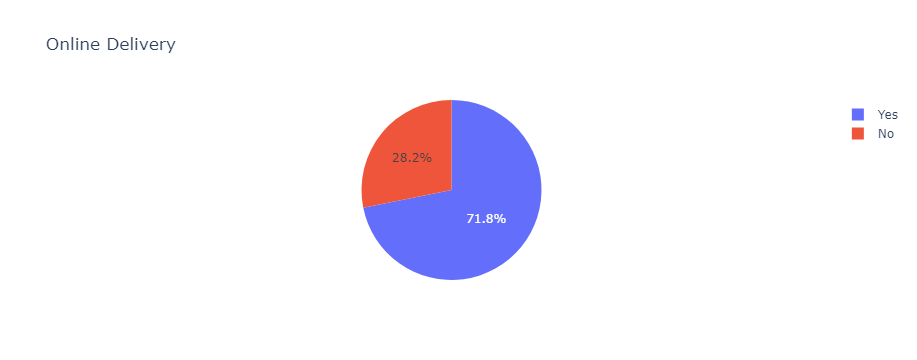

In [32]:
df=idf["Delivery"].value_counts()
fig = px.pie(values=df.values, names=df.index, title='Online Delivery')
py.iplot(fig)

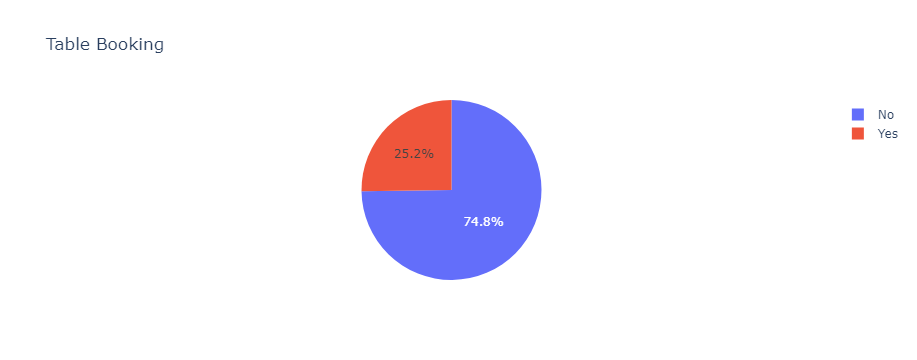

In [33]:
df=idf["Booking"].value_counts()
fig = px.pie(values=df.values, names=df.index, title='Table Booking')
py.iplot(fig)

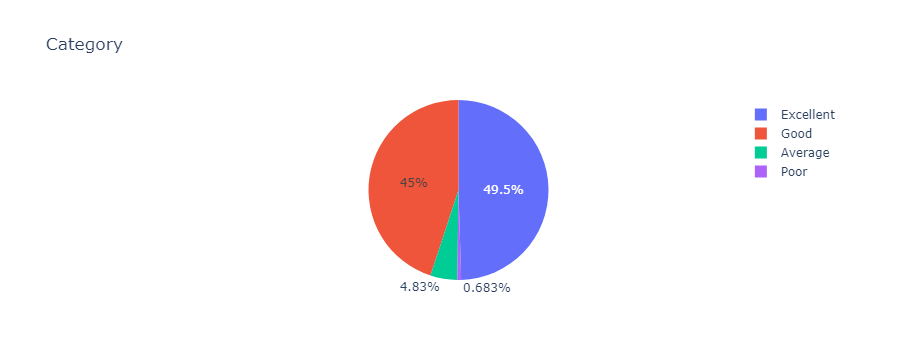

In [34]:
df=idf["Category"].value_counts()
fig = px.pie(values=df.values, names=df.index, title='Category')
py.iplot(fig)

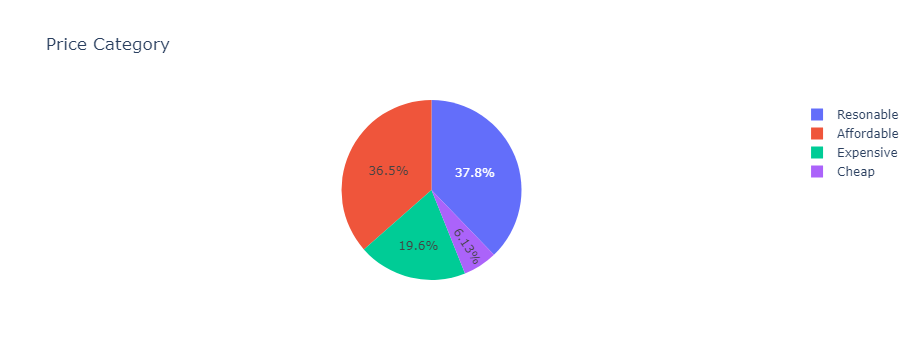

In [35]:
df=idf["Price_Category"].value_counts()
fig = px.pie(values=df.values, names=df.index, title='Price Category')
py.iplot(fig)

In [36]:
#Most Expensive Cities

inter=idf.groupby("City")[["Cost_Per_Person"]].mean()
sol=inter.sort_values(by="Cost_Per_Person",ascending=False).head()
sol.style.background_gradient(cmap="YlOrRd",high=0.5)

,Cost_Per_Person
City,
Lavelle Road,515.641026
Church Street,513.009165
Residency Road,507.262045
Brigade Road,502.995868
MG Road,500.569185


In [37]:
#Most Affordable Cities

inter=idf.groupby("City")[["Cost_Per_Person"]].mean()
sol=inter.sort_values(by="Cost_Per_Person").head()
sol.style.background_gradient(cmap="YlOrRd",high=0.5)

,Cost_Per_Person
City,
Banashankari,248.263889
Basavanagudi,279.953198
Bannerghatta Road,285.983333
JP Nagar,292.497156
Jayanagar,295.845656
